<a href="https://colab.research.google.com/github/ShauryaWadehra/object_detection_stuff/blob/main/classifier_2_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 3.7 kB/s 
     |████████████████████████████████| 454 kB 54.9 MB/s 
     |████████████████████████████████| 26.1 MB 45.3 MB/s 
     |████████████████████████████████| 3.0 MB 43.9 MB/s 
     |████████████████████████████████| 2.9 MB 41.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Unin

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/classifier-to-detector/classifier-to-detector.zip
!unzip -qq classifier-to-detector.zip
%cd classifier-to-detector

--2022-09-10 18:26:19--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/classifier-to-detector/classifier-to-detector.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.160.57
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.160.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245561 (240K) [binary/octet-stream]
Saving to: ‘classifier-to-detector.zip’

classifier-to-detec 100%[===================>] 239.81K  --.-KB/s    in 0.04s   

2022-09-10 18:26:20 (5.34 MB/s) - ‘classifier-to-detector.zip’ saved [245561/245561]

/content/classifier-to-detector


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2

In [3]:
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [4]:
def sliding_window(image, step, ws):
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [5]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	yield image
	while True:
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)		
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		yield image

In [12]:
args = {
	"image": "images/stingray.jpg",
	"size": "(300, 150)",
	"min_conf": 0.9,
	"visualize": 1
}

In [8]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)

In [9]:
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

[INFO] loading network...
102981632/102967424 [==============================] - 2s 0us/step


In [10]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [13]:
# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])

	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)

		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)

		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if args["visualize"] > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)

			# show the visualization and current ROI
			plt_imshow("Visualization", clone)
			plt_imshow("ROI", roiOrig)

In [14]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] looping over pyramid/windows took 103.62605 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 57.26102 seconds
49152/35363 [=========================================] - 0s 0us/step


In [15]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["min_conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]

		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'stingray'


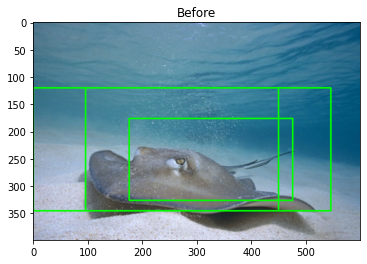

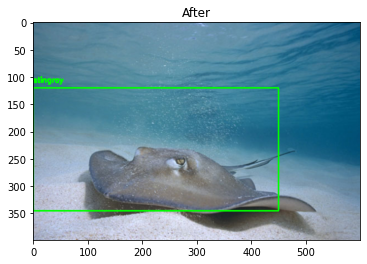

In [16]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = orig.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)